## Import library

In [1]:
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
print(torch.__version__)
import time
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.ticker as ticker
import scipy.io
import random
from utilities3 import *
from FNO3D import *

import operator
from functools import reduce
from functools import partial
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.ndimage.filters import gaussian_filter
from torch.utils.data import TensorDataset, random_split, DataLoader

# for reproduce
def seed_everything(seed=1234):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

seed_everything(202510)

mse_train = []
l2_test = []

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

2.5.1


/tmp/ipykernel_518325/553532504.py:19: DeprecationWarning: Please import `gaussian_filter` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.filters import gaussian_filter


## Load selected testing data (the size should be [60, 10, 70, 70]-> [num_vel, num_src, nz, nx])
#### Different from the out-of-distribution test, we use 20 different in-distribution vel models from each training family to obtain in total 60 vel models

In [2]:
# Computational model parameters
zmin = 0.;  deltaz = 0.01; zmax = 0.7;
xmin = 0.;  deltax = 0.01; xmax = 0.7;

vel_test = np.load('./data/selected_vel_test_in_distribution.npy')
T0_data_test = np.load('./data/T0data_test_in_distribution.npy')
T_data_test = np.load('./data/Tdata_test_in_distribution.npy')

test_T_data = torch.Tensor(T_data_test)
test_T0_data = torch.Tensor(T0_data_test)
test_tau = test_T_data - test_T0_data
nv_test, ns_test, nz_test, nx_test = test_T_data.shape
test_vel = torch.Tensor(np.array(vel_test)).repeat(ns_test, 1, 1, 1).permute(1, 0, 2, 3)
test_vel_right = 1/test_vel/test_vel
test_T0_input = torch.cat((test_T0_data.view(nv_test, ns_test, nz_test, nx_test, 1),
                           test_vel.view(nv_test, ns_test, nz_test, nx_test, 1)), dim=-1)
print('shape of test T0 input:', test_T0_input.shape)

# Dataset & loader
test_dataset = TensorDataset(test_T0_input, test_tau)
test_loader  = DataLoader(test_dataset, batch_size=50, shuffle=False, pin_memory=True)

shape of test T0 input: torch.Size([60, 10, 70, 70, 2])


## Test vel models visualization

torch.Size([60, 10, 70, 70])


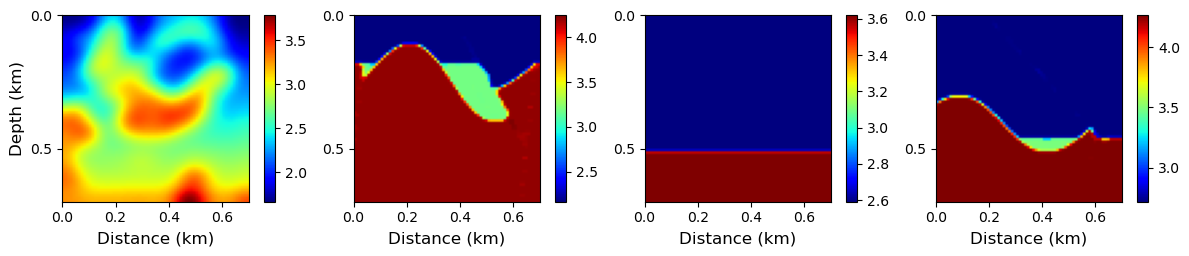

In [3]:
print(test_T_data.shape)

# Parameters
isou = 5
vel_indices = [5, 20, 30, 35]  # choose whichever you like
plt.style.use('default')

fig, axes = plt.subplots(1, len(vel_indices), figsize=(12, 4))
for i, iv in enumerate(vel_indices):
    ax = axes[i]
    im = ax.imshow(
        test_vel[iv, isou, :, :].cpu(),
        extent=[xmin, xmax, zmax, zmin],
        aspect=1,
        cmap="jet"
    )
    ax.set_xlabel('Distance (km)', fontsize=12)
    if i == 0:
        ax.set_ylabel('Depth (km)', fontsize=12)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(0.2))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(0.5))
    ax.tick_params(labelsize=10)

    # Colorbar
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="6%", pad=0.15)
    plt.colorbar(im, cax=cax)

plt.tight_layout()
# plt.savefig('./Fig/CurveVel.jpeg', dpi=400)
plt.show()

## Model inference

In [4]:
## please keep the hyperparameters below unchanged 
modes = 8
width = 16
epochs = 8000 #8000 for curvelet
learning_rate = 5e-4 #0.0025 for curvelet
scheduler_step = epochs//5
scheduler_gamma = 0.6
print(epochs, learning_rate, scheduler_step, scheduler_gamma)


model = Net3d(modes, width).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1*1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=scheduler_step, gamma=scheduler_gamma)

myloss = LpLoss(size_average=False)
mae = nn.L1Loss( reduction='sum')

Huber = nn.HuberLoss( reduction='sum')

ckpt_path = './models/multi_family_ep8000_data_driven.pth'
state = torch.load(ckpt_path, map_location=device, weights_only=True)
# If you recently added buffers in the model, you may need strict=False once:
model.load_state_dict(state)  # or: model.load_state_dict(state, strict=False)
model.eval()

8000 0.0005 1600 0.6


Net3d(
  (conv1): SimpleBlock3d(
    (fc0): Linear(in_features=2, out_features=16, bias=True)
    (conv0): SpectralConv3d_fast()
    (conv1): SpectralConv3d_fast()
    (conv2): SpectralConv3d_fast()
    (conv3): SpectralConv3d_fast()
    (conv4): SpectralConv3d_fast()
    (conv5): SpectralConv3d_fast()
    (conv6): SpectralConv3d_fast()
    (w0): Conv1d(16, 16, kernel_size=(1,), stride=(1,))
    (w1): Conv1d(16, 16, kernel_size=(1,), stride=(1,))
    (w2): Conv1d(16, 16, kernel_size=(1,), stride=(1,))
    (w3): Conv1d(16, 16, kernel_size=(1,), stride=(1,))
    (w4): Conv1d(16, 16, kernel_size=(1,), stride=(1,))
    (w5): Conv1d(16, 16, kernel_size=(1,), stride=(1,))
    (w6): Conv1d(16, 16, kernel_size=(1,), stride=(1,))
    (bn0): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bn1): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bn2): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=Tr

## Traveltime (T) comparison (truth vs prediction)

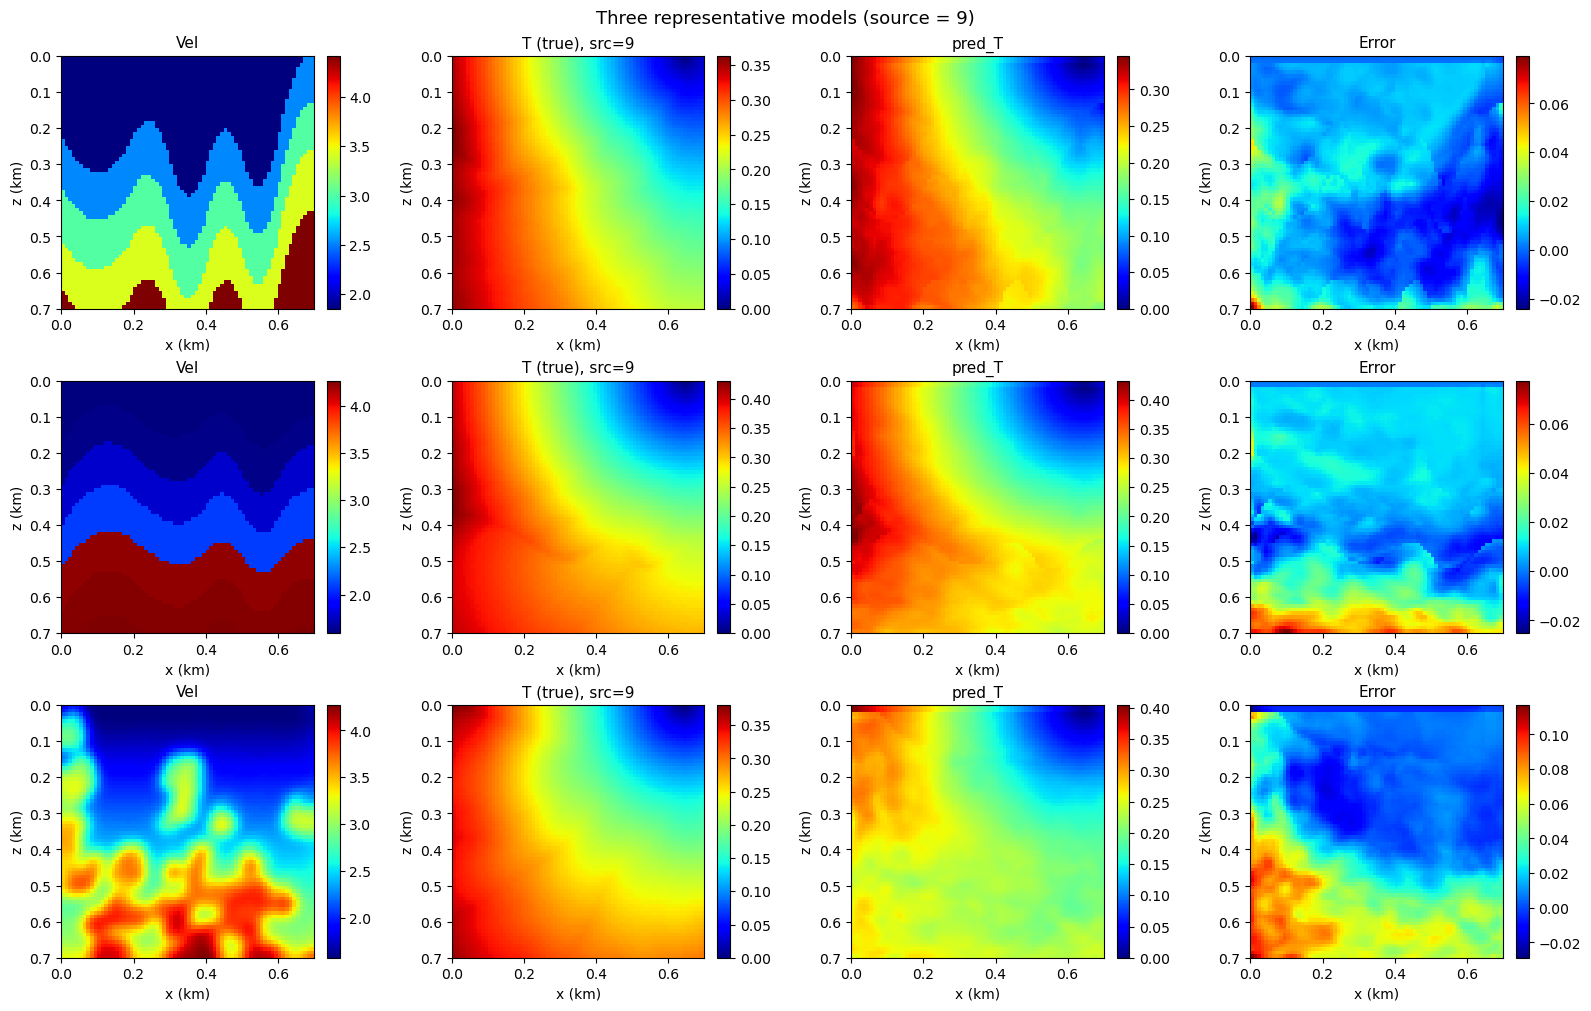

In [5]:
src_idx = 9 # source index to visualize
x = np.linspace(xmin, xmax, nx_test)
z = np.linspace(zmin, zmax, nz_test)
extent = [x.min(), x.max(), z.max(), z.min()]  # depth increases downward



# Run full prediction once
pred_tau_all = torch.zeros_like(test_tau)
start = 0

model.eval()
with torch.no_grad():
    for bx, (x_batch, y_batch) in enumerate(test_loader):
        B = x_batch.shape[0]
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        out_tau, _ = model(x_batch, y_batch)
        pred_tau_all[start:start+B] = out_tau.cpu()
        start += B

pred_T_all = test_T0_data + pred_tau_all
true_T_all = test_T_data
vel_all = test_vel

# Compute MAE per velocity model
per_vel_mae = torch.mean(torch.abs(true_T_all - pred_T_all), dim=(1,2,3)).numpy()
order = np.argsort(per_vel_mae)
rep_indices = [order[5], order[len(order)//2], order[-10]]
rep_labels = [
    f"Best (MAE={per_vel_mae[order[0]]:.4g})",
    f"Median (MAE={per_vel_mae[order[len(order)//2]]:.4g})",
    f"Worst (MAE={per_vel_mae[order[-1]]:.4g})"
]

# Plot each representative model
fig, axes = plt.subplots(len(rep_indices), 4, figsize=(16, 10), constrained_layout=True)

def show(ax, data, title):
    im = ax.imshow(data, extent=extent, origin='upper', aspect='equal', cmap='jet')
    ax.set_title(title, fontsize=11)
    ax.set_xlabel('x (km)')
    ax.set_ylabel('z (km)')
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

for r, (vi, lbl) in enumerate(zip(rep_indices, rep_labels)):
    vel_2d = vel_all[vi, src_idx].cpu().numpy()
    T_2d = true_T_all[vi, src_idx].cpu().numpy()
    pred_2d = pred_T_all[vi, src_idx].cpu().numpy()
    res_2d = T_2d - pred_2d

    show(axes[r, 0], vel_2d, f'Vel')
    show(axes[r, 1], T_2d, f'T (true), src={src_idx}')
    show(axes[r, 2], pred_2d, 'pred_T')
    show(axes[r, 3], res_2d, 'Error')

fig.suptitle(f'Three representative models (source = {src_idx})', fontsize=13)
plt.savefig(f'./figs/data_driven_fno_id_test_src{src_idx}_T.png', dpi=300)
plt.show()

## Traveltime (Tau) comparison (truth vs prediction)

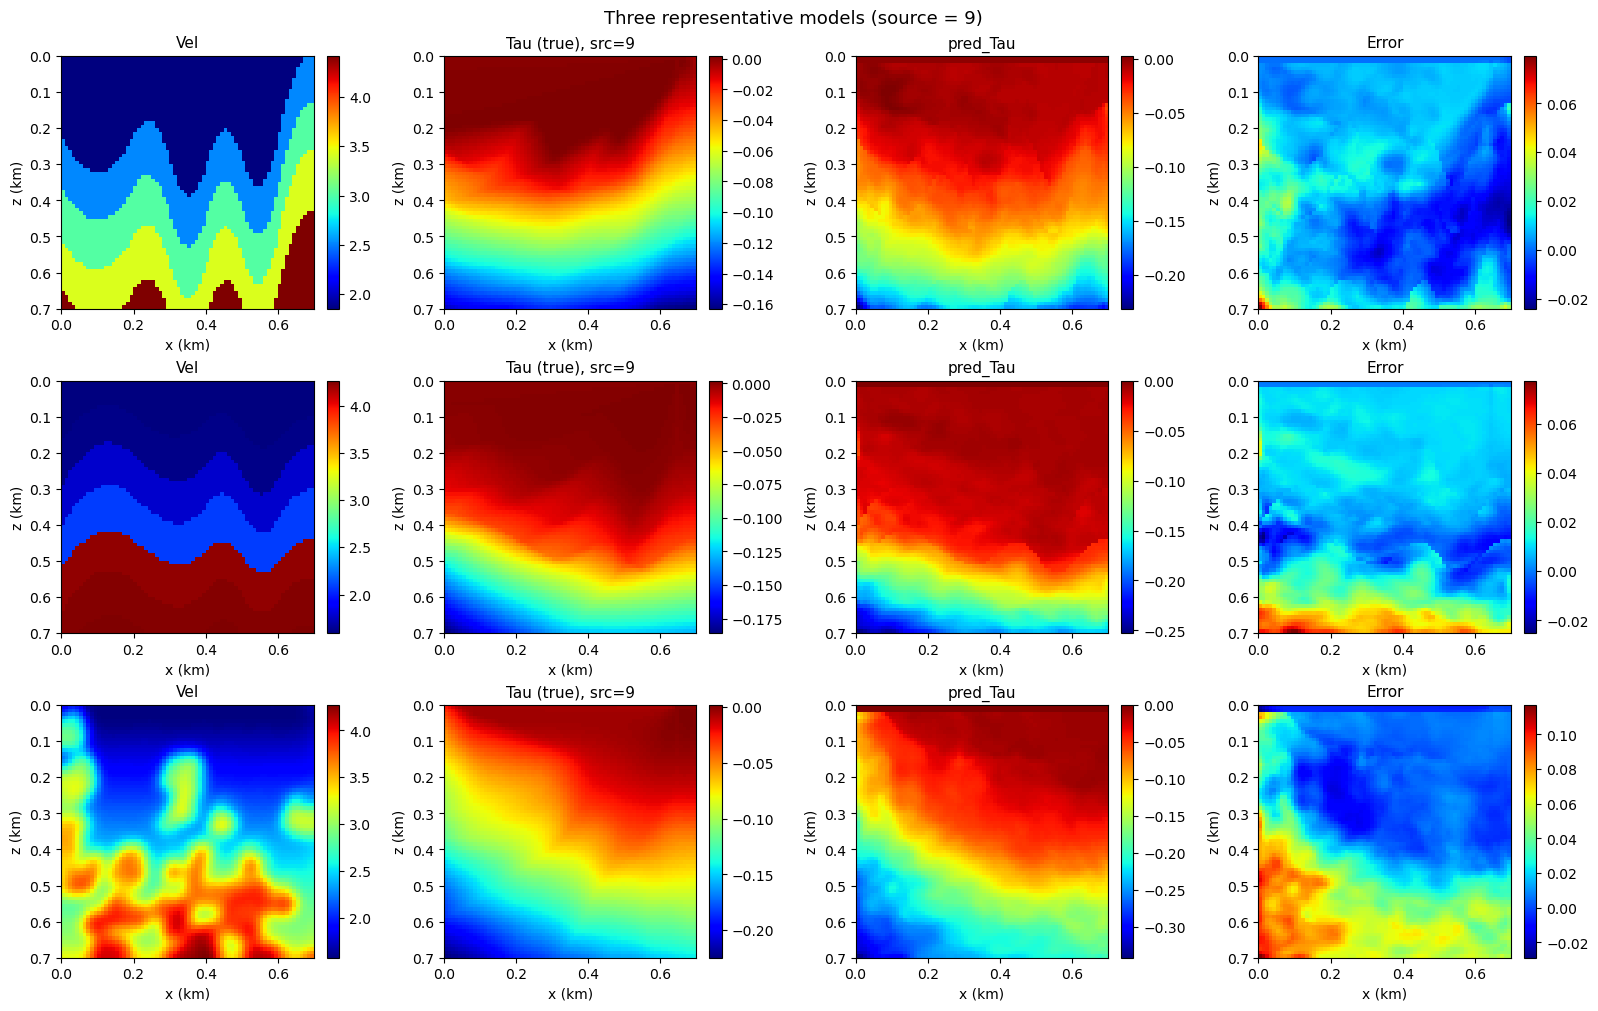

In [6]:
true_tau_all = test_tau
vel_all = test_vel

# Compute MAE per velocity model
per_vel_mae = torch.mean(torch.abs(true_tau_all - pred_tau_all), dim=(1,2,3)).numpy()
order = np.argsort(per_vel_mae)


# Plot each representative model
fig, axes = plt.subplots(len(rep_indices), 4, figsize=(16, 10), constrained_layout=True)

def show(ax, data, title):
    im = ax.imshow(data, extent=extent, origin='upper', aspect='equal', cmap='jet')
    ax.set_title(title, fontsize=11)
    ax.set_xlabel('x (km)')
    ax.set_ylabel('z (km)')
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

for r, (vi, lbl) in enumerate(zip(rep_indices, rep_labels)):
    vel_2d = vel_all[vi, src_idx].cpu().numpy()
    T_2d = true_tau_all[vi, src_idx].cpu().numpy()
    pred_2d = pred_tau_all[vi, src_idx].cpu().numpy()
    res_2d = T_2d - pred_2d

    show(axes[r, 0], vel_2d, f'Vel')
    show(axes[r, 1], T_2d, f'Tau (true), src={src_idx}')
    show(axes[r, 2], pred_2d, 'pred_Tau')
    show(axes[r, 3], res_2d, 'Error')

fig.suptitle(f'Three representative models (source = {src_idx})', fontsize=13)
plt.savefig(f'./figs/data_driven_fno_id_test_src{src_idx}_Tau.png', dpi=300)
plt.show()